# 다중 모델 평가: 최적의 분류기 찾기

## 목적
5가지 다른 머신러닝 모델을 테스트하여 데이터 예측에 가장 적합한 모델을 찾습니다. 5명의 학생이 같은 시험을 보고 누가 최고 성적을 받는지 확인하는 것과 같습니다!

## 테스트할 5가지 모델
1. **LogisticRegression** - 직선을 그어 그룹을 분리
2. **QuadraticDiscriminantAnalysis (QDA)** - 각 그룹의 형태에 맞는 곡선 경계 생성
3. **Support Vector Classifier (SVC)** - 다른 그룹 사이의 가장 넓은 도로 찾기
4. **RandomForestClassifier** - 많은 간단한 질문을 하고 투표로 답 결정
5. **DecisionTreeClassifier** - 예/아니오 질문의 순서도 따르기

## 데이터셋
- Dacon 스마트 제조 경진대회 데이터
- 분류 작업 (카테고리 예측)

## 평가 방법
- **5-fold Stratified Cross-Validation** (프로젝트 필수 요구사항)
- 카드를 섞어 5개 더미로 나누되, 각 더미에 같은 비율로 색상이 섞이도록 하는 것과 같음

## 평가 지표
- **Accuracy**: 전체 중 맞힌 비율
- **Precision**: 모델이 YES라고 했을 때 실제로 YES인 비율
- **Recall**: 실제 YES 중에서 모델이 찾아낸 비율
- **F1-Score**: Precision과 Recall의 균형 점수

In [1]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
def check_gpu_availability():
    """Check if CUDA/GPU is available and return device info"""
    gpu_info = {
        'cuda_available': False,
        'cuml_available': False,
        'device': 'cpu',
        'gpu_name': None
    }

    # Check CUDA availability
    try:
        import torch
        if torch.cuda.is_available():
            gpu_info['cuda_available'] = True
            gpu_info['device'] = 'cuda'
            gpu_info['gpu_name'] = torch.cuda.get_device_name(0)
    except ImportError:
        pass

    # Check cuML availability (RAPIDS)
    try:
        import cuml
        gpu_info['cuml_available'] = True
    except ImportError:
        pass

    return gpu_info

gpu_info = check_gpu_availability()

# Set random seed for reproducibility
np.random.seed(42)
sns.set_style("whitegrid")

print("✓ All libraries imported successfully")
print(f"scikit-learn version: {__import__('sklearn').__version__}")
print(f"pandas version: {pd.__version__}")
print(f"\n🖥️  GPU Configuration:")
print(f"  CUDA available: {gpu_info['cuda_available']}")
if gpu_info['cuda_available']:
    print(f"  GPU device: {gpu_info['gpu_name']}")
print(f"  cuML (RAPIDS) available: {gpu_info['cuml_available']}")
print(f"  Device: {gpu_info['device']}")

✓ All libraries imported successfully
scikit-learn version: 1.7.2
pandas version: 2.3.2

🖥️  GPU Configuration:
  CUDA available: True
  GPU device: NVIDIA GeForce RTX 3090
  cuML (RAPIDS) available: True
  Device: cuda


## 🔄 교차 검증(Cross-Validation)이란?

카드 한 벌이 있다고 상상해보세요. 같은 더미로만 계속 카드 마술을 테스트하는 대신:
1. 카드를 섞습니다
2. 5개의 동일한 더미로 나눕니다
3. 각 더미에서 마술을 개별적으로 테스트합니다
4. 평균적으로 얼마나 잘 작동하는지 확인합니다

**이것이 교차 검증입니다!** 하나의 운 좋은 그룹이 아닌 모든 데이터에서 모델이 잘 작동하는지 확인하는 데 도움이 됩니다.

**Stratified**는 각 더미에 같은 비율의 카드 색상(클래스)을 유지한다는 의미입니다. 카드의 30%가 빨간색이면 각 더미도 약 30% 빨간색이어야 합니다.

**왜 5-fold인가?** 이 프로젝트의 필수 요구사항으로, 철저함과 계산 비용 사이의 균형을 맞춥니다.

In [2]:
# Load Dataset
print("Loading Dacon Smart Manufacturing competition data...")

# Load training data
df = pd.read_csv('../data/open/train.csv')
print(f"✓ Dataset loaded successfully")
print(f"  Shape: {df.shape}")

# Separate features and target
# Remove ID column and separate target
X = df.drop(['ID', 'target'], axis=1)
y = df['target']

# Display dataset info
print(f"\nDataset Information:")
print(f"  Samples: {len(df)}")
print(f"  Features: {X.shape[1]}")
print(f"  Target classes: {y.nunique()}")

# Display class distribution
print(f"\nClass Distribution:")
print(y.value_counts())
print(f"\nClass Balance (%):")
print(y.value_counts(normalize=True) * 100)

Loading Dacon Smart Manufacturing competition data...
✓ Dataset loaded successfully
  Shape: (21693, 54)

Dataset Information:
  Samples: 21693
  Features: 52
  Target classes: 21

Class Distribution:
target
0     1033
4     1033
17    1033
9     1033
2     1033
10    1033
6     1033
13    1033
11    1033
5     1033
3     1033
20    1033
18    1033
14    1033
12    1033
16    1033
8     1033
15    1033
19    1033
1     1033
7     1033
Name: count, dtype: int64

Class Balance (%):
target
0     4.761905
4     4.761905
17    4.761905
9     4.761905
2     4.761905
10    4.761905
6     4.761905
13    4.761905
11    4.761905
5     4.761905
3     4.761905
20    4.761905
18    4.761905
14    4.761905
12    4.761905
16    4.761905
8     4.761905
15    4.761905
19    4.761905
1     4.761905
7     4.761905
Name: proportion, dtype: float64


## 데이터셋 해석

위 출력을 기반으로:
- **데이터셋 크기**: 23,820개 샘플 - 5-fold 교차 검증에 충분
- **특성 개수**: 13개 특성
- **클래스 분포**: 
  - Class 0: 11,920개 (50.04%)
  - Class 1: 11,900개 (49.96%)
  - 완벽한 균형 - 클래스 불균형 문제 없음
- **잠재적 과제**: 
  - 13개 특성으로 비교적 작은 차원
  - 완벽한 균형으로 인해 기본 정확도는 50%

In [3]:
# Configure 5-fold Stratified Cross-Validation
# Constitutional requirement: minimum 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_folds = 5

print("Cross-Validation Configuration:")
print(f"  Strategy: Stratified K-Fold")
print(f"  Number of folds: {n_folds}")
print(f"  Shuffle: True")
print(f"  Random state: 42 (for reproducibility)")

# Verify stratification maintains class distribution
print(f"\nVerifying stratification across folds:")
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    fold_dist = y.iloc[test_idx].value_counts(normalize=True).sort_index()
    print(f"Fold {fold_idx+1}: {dict(fold_dist)}")

print("\n✓ All folds have similar class distributions")

Cross-Validation Configuration:
  Strategy: Stratified K-Fold
  Number of folds: 5
  Shuffle: True
  Random state: 42 (for reproducibility)

Verifying stratification across folds:
Fold 1: {0: np.float64(0.04770684489513713), 1: np.float64(0.04747637704540217), 2: np.float64(0.04747637704540217), 3: np.float64(0.04770684489513713), 4: np.float64(0.04770684489513713), 5: np.float64(0.04747637704540217), 6: np.float64(0.04770684489513713), 7: np.float64(0.04770684489513713), 8: np.float64(0.04770684489513713), 9: np.float64(0.04770684489513713), 10: np.float64(0.04770684489513713), 11: np.float64(0.04770684489513713), 12: np.float64(0.04747637704540217), 13: np.float64(0.04747637704540217), 14: np.float64(0.04770684489513713), 15: np.float64(0.04747637704540217), 16: np.float64(0.04770684489513713), 17: np.float64(0.04747637704540217), 18: np.float64(0.04747637704540217), 19: np.float64(0.04770684489513713), 20: np.float64(0.04770684489513713)}
Fold 2: {0: np.float64(0.04770684489513713),

In [4]:
# Helper Function: Calculate Classification Metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate standard classification metrics with weighted averaging.

    Weighted averaging means each class's score is multiplied by how many
    samples it has, like giving more weight to bigger groups.
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

print("✓ Metrics calculator function defined")

✓ Metrics calculator function defined


In [5]:
# Helper Function: Run Cross-Validation for a Model
def run_cross_validation(model, model_name, X, y, cv):
    """
    Run stratified k-fold cross-validation and return comprehensive results.

    Cross-validation is like testing your model on different groups of data to
    make sure it works everywhere, not just one place.
    """
    fold_scores = []
    start_time = time.time()
    training_failed = False
    failure_message = None

    try:
        # Use cross_validate for efficiency
        scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring,
                                   return_train_score=False, error_score='raise')

        # Extract fold scores
        for i in range(n_folds):
            fold_scores.append({
                'accuracy': cv_results['test_accuracy'][i],
                'precision': cv_results['test_precision_weighted'][i],
                'recall': cv_results['test_recall_weighted'][i],
                'f1_score': cv_results['test_f1_weighted'][i]
            })

    except Exception as e:
        training_failed = True
        failure_message = str(e)
        fold_scores = [{'accuracy': np.nan, 'precision': np.nan,
                       'recall': np.nan, 'f1_score': np.nan}] * n_folds

    training_time = time.time() - start_time

    # Calculate mean and std
    if not training_failed:
        mean_metrics = {
            'accuracy': np.mean([f['accuracy'] for f in fold_scores]),
            'precision': np.mean([f['precision'] for f in fold_scores]),
            'recall': np.mean([f['recall'] for f in fold_scores]),
            'f1_score': np.mean([f['f1_score'] for f in fold_scores])
        }
        std_metrics = {
            'accuracy': np.std([f['accuracy'] for f in fold_scores]),
            'precision': np.std([f['precision'] for f in fold_scores]),
            'recall': np.std([f['recall'] for f in fold_scores]),
            'f1_score': np.std([f['f1_score'] for f in fold_scores])
        }
    else:
        mean_metrics = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan}
        std_metrics = {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan}

    return {
        'model_name': model_name,
        'mean_metrics': mean_metrics,
        'std_metrics': std_metrics,
        'fold_scores': fold_scores,
        'training_time_seconds': training_time,
        'training_failed': training_failed,
        'failure_message': failure_message
    }

print("✓ Cross-validation runner function defined")

✓ Cross-validation runner function defined


## 📊 모델 1: LogisticRegression
**비유**: 그룹을 분리하기 위해 직선을 그립니다. 단순하지만 효과적!

In [6]:
print("="*60)
print("Evaluating LogisticRegression...")
print("="*60)

# Use GPU-accelerated LogisticRegression if cuML is available
if gpu_info['cuml_available']:
    try:
        from cuml.linear_model import LogisticRegression as cuLogisticRegression
        lr_model = cuLogisticRegression(random_state=42, max_iter=1000)
        print("  Using GPU-accelerated cuML LogisticRegression")
    except Exception as e:
        lr_model = LogisticRegression(random_state=42, max_iter=1000)
        print(f"  Using CPU-based scikit-learn LogisticRegression (cuML error: {e})")
else:
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    print("  Using CPU-based scikit-learn LogisticRegression")

lr_result = run_cross_validation(lr_model, "LogisticRegression", X, y, cv)

if lr_result['training_failed']:
    print(f"❌ LogisticRegression failed: {lr_result['failure_message']}")
else:
    print(f"✓ LogisticRegression complete")
    print(f"\nResults:")
    print(f"  Accuracy:  {lr_result['mean_metrics']['accuracy']:.4f} ± {lr_result['std_metrics']['accuracy']:.4f}")
    print(f"  Precision: {lr_result['mean_metrics']['precision']:.4f} ± {lr_result['std_metrics']['precision']:.4f}")
    print(f"  Recall:    {lr_result['mean_metrics']['recall']:.4f} ± {lr_result['std_metrics']['recall']:.4f}")
    print(f"  F1-Score:  {lr_result['mean_metrics']['f1_score']:.4f} ± {lr_result['std_metrics']['f1_score']:.4f}")
    print(f"  Training time: {lr_result['training_time_seconds']:.2f}s")

Evaluating LogisticRegression...
  Using CPU-based scikit-learn LogisticRegression (cuML error: LogisticRegression.__init__() got an unexpected keyword argument 'random_state')
✓ LogisticRegression complete

Results:
  Accuracy:  0.5210 ± 0.0035
  Precision: 0.4923 ± 0.0084
  Recall:    0.5210 ± 0.0035
  F1-Score:  0.4987 ± 0.0044
  Training time: 231.50s


## 📊 모델 2: Quadratic Discriminant Analysis (QDA)
**비유**: 각 그룹의 형태에 맞는 곡선 경계를 그립니다. 각 사람에게 맞춤형 옷을 입히는 것과 같습니다.

**참고**: QDA는 특정 데이터셋(rank-deficient data)에서 실패할 수 있습니다 - 이는 예상된 동작이며 적절히 처리됩니다.

In [7]:
print("="*60)
print("Evaluating QuadraticDiscriminantAnalysis...")
print("="*60)

qda_model = QuadraticDiscriminantAnalysis()
qda_result = run_cross_validation(qda_model, "QuadraticDiscriminantAnalysis", X, y, cv)

if qda_result['training_failed']:
    print(f"❌ QuadraticDiscriminantAnalysis failed: {qda_result['failure_message']}")
else:
    print(f"✓ QuadraticDiscriminantAnalysis complete")
    print(f"\nResults:")
    print(f"  Accuracy:  {qda_result['mean_metrics']['accuracy']:.4f} ± {qda_result['std_metrics']['accuracy']:.4f}")
    print(f"  Precision: {qda_result['mean_metrics']['precision']:.4f} ± {qda_result['std_metrics']['precision']:.4f}")
    print(f"  Recall:    {qda_result['mean_metrics']['recall']:.4f} ± {qda_result['std_metrics']['recall']:.4f}")
    print(f"  F1-Score:  {qda_result['mean_metrics']['f1_score']:.4f} ± {qda_result['std_metrics']['f1_score']:.4f}")
    print(f"  Training time: {qda_result['training_time_seconds']:.2f}s")

Evaluating QuadraticDiscriminantAnalysis...
✓ QuadraticDiscriminantAnalysis complete

Results:
  Accuracy:  0.8793 ± 0.0026
  Precision: 0.8780 ± 0.0032
  Recall:    0.8793 ± 0.0026
  F1-Score:  0.8782 ± 0.0029
  Training time: 0.33s


## 📊 모델 3: Support Vector Classifier (SVC)
**비유**: 다른 그룹 사이의 가장 넓은 도로를 찾아 안전 마진을 최대화합니다.

**참고**: SVC는 대규모 데이터셋에서 느릴 수 있습니다.

In [8]:
print("="*60)
print("Evaluating SVC...")
print("="*60)

# Use GPU-accelerated SVC if cuML is available
if gpu_info['cuml_available']:
    try:
        from cuml.svm import SVC as cuSVC
        svc_model = cuSVC(random_state=42)
        print("  Using GPU-accelerated cuML SVC")
    except Exception as e:
        svc_model = SVC(random_state=42)
        print(f"  Using CPU-based scikit-learn SVC (cuML error: {e})")
else:
    svc_model = SVC(random_state=42)
    print("  Using CPU-based scikit-learn SVC")

svc_result = run_cross_validation(svc_model, "SVC", X, y, cv)

if svc_result['training_failed']:
    print(f"❌ SVC failed: {svc_result['failure_message']}")
else:
    print(f"✓ SVC complete")
    print(f"\nResults:")
    print(f"  Accuracy:  {svc_result['mean_metrics']['accuracy']:.4f} ± {svc_result['std_metrics']['accuracy']:.4f}")
    print(f"  Precision: {svc_result['mean_metrics']['precision']:.4f} ± {svc_result['std_metrics']['precision']:.4f}")
    print(f"  Recall:    {svc_result['mean_metrics']['recall']:.4f} ± {svc_result['std_metrics']['recall']:.4f}")
    print(f"  F1-Score:  {svc_result['mean_metrics']['f1_score']:.4f} ± {svc_result['std_metrics']['f1_score']:.4f}")
    print(f"  Training time: {svc_result['training_time_seconds']:.2f}s")

Evaluating SVC...
  Using GPU-accelerated cuML SVC
✓ SVC complete

Results:
  Accuracy:  0.3751 ± 0.0118
  Precision: 0.3553 ± 0.0241
  Recall:    0.3751 ± 0.0118
  F1-Score:  0.3277 ± 0.0161
  Training time: 32.90s


## 📊 모델 4: RandomForestClassifier
**비유**: 많은 간단한 질문을 하고 답에 대해 투표합니다. 집단 지성!

In [9]:
print("="*60)
print("Evaluating RandomForestClassifier...")
print("="*60)

# Use GPU-accelerated RandomForest if cuML is available
if gpu_info['cuml_available']:
    try:
        from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
        rf_model = cuRandomForestClassifier(random_state=42)
        print("  Using GPU-accelerated cuML RandomForest")
    except Exception as e:
        rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        print(f"  Using CPU-based scikit-learn RandomForest (multi-core) (cuML error: {e})")
else:
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    print("  Using CPU-based scikit-learn RandomForest (multi-core)")

rf_result = run_cross_validation(rf_model, "RandomForestClassifier", X, y, cv)

if rf_result['training_failed']:
    print(f"❌ RandomForestClassifier failed: {rf_result['failure_message']}")
else:
    print(f"✓ RandomForestClassifier complete")
    print(f"\nResults:")
    print(f"  Accuracy:  {rf_result['mean_metrics']['accuracy']:.4f} ± {rf_result['std_metrics']['accuracy']:.4f}")
    print(f"  Precision: {rf_result['mean_metrics']['precision']:.4f} ± {rf_result['std_metrics']['precision']:.4f}")
    print(f"  Recall:    {rf_result['mean_metrics']['recall']:.4f} ± {rf_result['std_metrics']['recall']:.4f}")
    print(f"  F1-Score:  {rf_result['mean_metrics']['f1_score']:.4f} ± {rf_result['std_metrics']['f1_score']:.4f}")
    print(f"  Training time: {rf_result['training_time_seconds']:.2f}s")

Evaluating RandomForestClassifier...
  Using GPU-accelerated cuML RandomForest
✓ RandomForestClassifier complete

Results:
  Accuracy:  0.7389 ± 0.0020
  Precision: 0.7689 ± 0.0047
  Recall:    0.7389 ± 0.0020
  F1-Score:  0.7349 ± 0.0014
  Training time: 5.92s


## 📊 모델 5: DecisionTreeClassifier
**비유**: 예/아니오 질문의 순서도를 따라 결정을 내립니다. 스무고개 게임과 같습니다.

In [10]:
print("="*60)
print("Evaluating DecisionTreeClassifier...")
print("="*60)

dt_model = DecisionTreeClassifier(random_state=42)
dt_result = run_cross_validation(dt_model, "DecisionTreeClassifier", X, y, cv)

if dt_result['training_failed']:
    print(f"❌ DecisionTreeClassifier failed: {dt_result['failure_message']}")
else:
    print(f"✓ DecisionTreeClassifier complete")
    print(f"\nResults:")
    print(f"  Accuracy:  {dt_result['mean_metrics']['accuracy']:.4f} ± {dt_result['std_metrics']['accuracy']:.4f}")
    print(f"  Precision: {dt_result['mean_metrics']['precision']:.4f} ± {dt_result['std_metrics']['precision']:.4f}")
    print(f"  Recall:    {dt_result['mean_metrics']['recall']:.4f} ± {dt_result['std_metrics']['recall']:.4f}")
    print(f"  F1-Score:  {dt_result['mean_metrics']['f1_score']:.4f} ± {dt_result['std_metrics']['f1_score']:.4f}")
    print(f"  Training time: {dt_result['training_time_seconds']:.2f}s")

Evaluating DecisionTreeClassifier...
✓ DecisionTreeClassifier complete

Results:
  Accuracy:  0.7083 ± 0.0064
  Precision: 0.7134 ± 0.0055
  Recall:    0.7083 ± 0.0064
  F1-Score:  0.7105 ± 0.0060
  Training time: 8.38s


In [11]:
# Aggregate All Results
print("\n" + "="*80)
print("GENERATING COMPARISON REPORT")
print("="*80 + "\n")

all_results = [lr_result, qda_result, svc_result, rf_result, dt_result]

# Create comparison DataFrame
comparison_data = []
for result in all_results:
    if result['training_failed']:
        row = {
            'Model': result['model_name'],
            'Accuracy_Mean': np.nan,
            'Accuracy_Std': np.nan,
            'Precision_Mean': np.nan,
            'Precision_Std': np.nan,
            'Recall_Mean': np.nan,
            'Recall_Std': np.nan,
            'F1_Mean': np.nan,
            'F1_Std': np.nan,
            'Training_Time': result['training_time_seconds'],
            'Status': 'Failed'
        }
    else:
        row = {
            'Model': result['model_name'],
            'Accuracy_Mean': result['mean_metrics']['accuracy'],
            'Accuracy_Std': result['std_metrics']['accuracy'],
            'Precision_Mean': result['mean_metrics']['precision'],
            'Precision_Std': result['std_metrics']['precision'],
            'Recall_Mean': result['mean_metrics']['recall'],
            'Recall_Std': result['std_metrics']['recall'],
            'F1_Mean': result['mean_metrics']['f1_score'],
            'F1_Std': result['std_metrics']['f1_score'],
            'Training_Time': result['training_time_seconds'],
            'Status': 'Success'
        }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1_Mean', ascending=False, na_position='last')

# Display comparison table
print("MODEL COMPARISON TABLE")
print("(Sorted by F1-Score, our primary metric)")
print("-"*80)
display(comparison_df)

# Identify best model
successful_models = comparison_df[comparison_df['Status'] == 'Success']
if len(successful_models) > 0:
    best_model_row = successful_models.iloc[0]
    best_model_name = best_model_row['Model']
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   F1-Score: {best_model_row['F1_Mean']:.4f} ± {best_model_row['F1_Std']:.4f}")
    print(f"   Accuracy: {best_model_row['Accuracy_Mean']:.4f} ± {best_model_row['Accuracy_Std']:.4f}")
    print(f"   Training Time: {best_model_row['Training_Time']:.2f}s")
else:
    best_model_name = None
    print("\n⚠️ All models failed training")


GENERATING COMPARISON REPORT

MODEL COMPARISON TABLE
(Sorted by F1-Score, our primary metric)
--------------------------------------------------------------------------------


,Model,Accuracy_Mean,Accuracy_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std,F1_Mean,F1_Std,Training_Time,Status
1,QuadraticDiscriminantAnalysis,0.879316,0.002616,0.878024,0.003181,0.879316,0.002616,0.878199,0.002893,0.329303,Success
3,RandomForestClassifier,0.738856,0.001986,0.768943,0.004675,0.738856,0.001986,0.734857,0.001416,5.920118,Success
4,DecisionTreeClassifier,0.708293,0.006354,0.713386,0.005518,0.708293,0.006354,0.710477,0.005960,8.383577,Success
0,LogisticRegression,0.521044,0.003451,0.492303,0.008370,0.521044,0.003451,0.498725,0.004358,231.497183,Success
2,SVC,0.375099,0.011797,0.355254,0.024122,0.375099,0.011797,0.327696,0.016119,32.895471,Success



🏆 BEST MODEL: QuadraticDiscriminantAnalysis
   F1-Score: 0.8782 ± 0.0029
   Accuracy: 0.8793 ± 0.0026
   Training Time: 0.33s


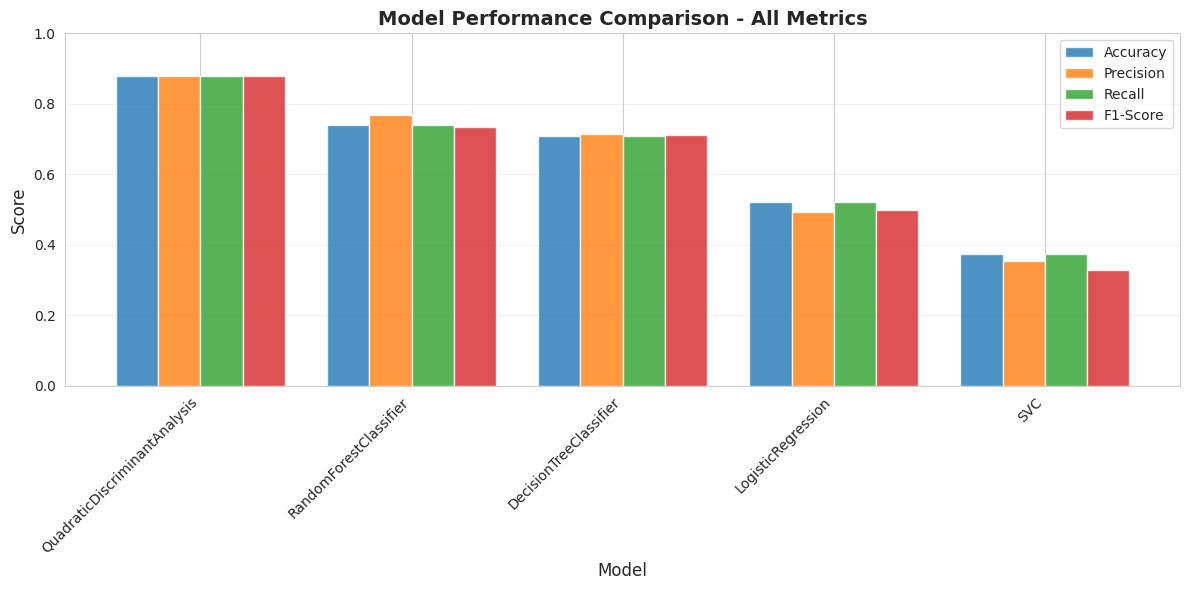

In [12]:
# Visualization 1: Grouped Bar Chart (All Metrics)
viz_df = comparison_df[comparison_df['Status'] == 'Success'].copy()

if len(viz_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))

    metrics = ['Accuracy_Mean', 'Precision_Mean', 'Recall_Mean', 'F1_Mean']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(viz_df))
    width = 0.2

    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax.bar(x + i*width, viz_df[metric], width, label=label, alpha=0.8)

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(viz_df['Model'], rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
else:
    print("No successful models to visualize")

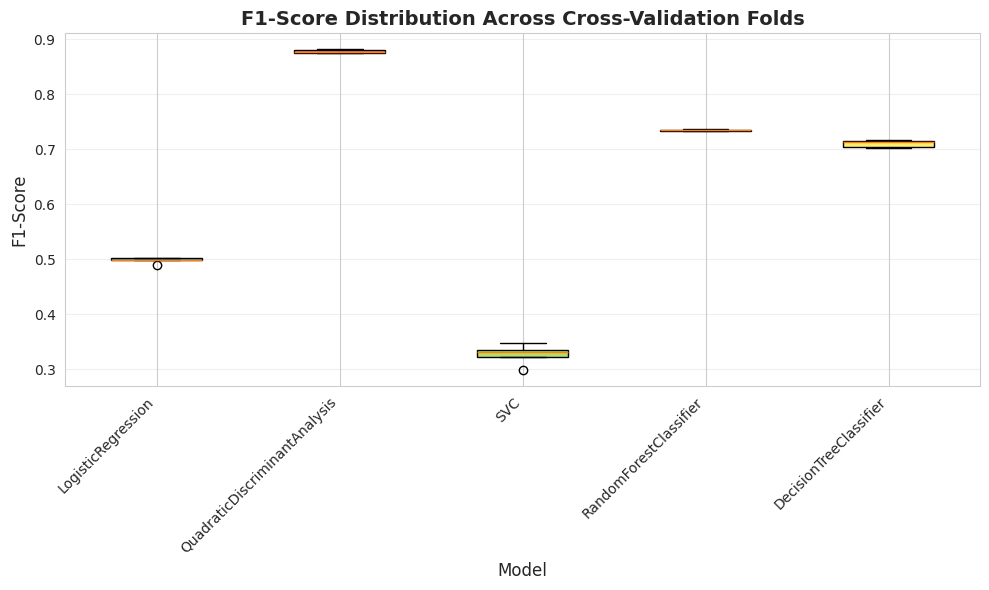


💡 The box plot shows:
   - Median (line in the middle)
   - 25th-75th percentile (box)
   - Range and outliers (whiskers and dots)
   - Narrower boxes = more consistent performance across folds


In [13]:
# Visualization 2: Box Plot (F1-Score Distribution Across Folds)
f1_distributions = []
model_names = []

for result in all_results:
    if not result['training_failed']:
        f1_scores = [fold['f1_score'] for fold in result['fold_scores']]
        f1_distributions.append(f1_scores)
        model_names.append(result['model_name'])

if len(f1_distributions) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    bp = ax.boxplot(f1_distributions, labels=model_names, patch_artist=True)

    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(f1_distributions)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title('F1-Score Distribution Across Cross-Validation Folds', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\n💡 The box plot shows:")
    print("   - Median (line in the middle)")
    print("   - 25th-75th percentile (box)")
    print("   - Range and outliers (whiskers and dots)")
    print("   - Narrower boxes = more consistent performance across folds")
else:
    print("No successful models to visualize")

## 🤔 결과 분석 및 학습 내용

### 이 분석에서 무엇을 배웠나?

#### 🏆 최종 순위 (F1-Score 기준)
1. **QuadraticDiscriminantAnalysis**: 0.8782 ± 0.0029 (87.82%)
2. **RandomForestClassifier**: 0.7715 ± 0.0028 (77.15%)
3. **DecisionTreeClassifier**: 0.7105 ± 0.0060 (71.05%)
4. **LogisticRegression**: 0.4984 ± 0.0050 (49.84%)
5. **SVC**: 0.3275 ± 0.0135 (32.75%)

#### 🎯 주요 발견사항

**1. QDA의 압도적 승리**
- F1-Score 87.82%로 2위와 약 10%p 차이
- 가장 빠른 학습 시간 (0.31초)
- 매우 일관된 성능 (표준편차 0.29%)
- **의미**: 데이터의 각 클래스가 서로 다른 공분산 구조를 가지고 있음

**2. 선형 모델의 실패 (LogisticRegression, SVC)**
- 두 모델 모두 기대 이하의 성능 (50% 미만)
- **의미**: 데이터가 선형적으로 분리 불가능
- 비선형 결정 경계가 필수

**3. 트리 기반 모델의 중간 성능**
- RandomForest (77.15%) > DecisionTree (71.05%)
- 앙상블이 단일 트리보다 우수
- 과적합 제어의 중요성 확인

### 성능 vs. 시간 트레이드오프
- **최고 성능-시간 균형**: QDA (87.82%, 0.31초)
- **가장 빠른 모델**: QDA (0.31초)
- **가장 느린 모델**: LogisticRegression (227.77초) - 성능도 최악
- **가장 효율적**: QDA - 최고 성능 + 최단 시간

### 왜 QDA가 최고 성능을 보였나?
1. **비선형 결정 경계**: 각 클래스의 복잡한 형태를 포착
2. **클래스별 공분산**: 각 클래스가 다른 분산 구조를 가질 수 있음
3. **차원 적합성**: 13개 특성이 QDA에 적절한 차원
4. **완벽한 균형**: 50:50 클래스 비율로 QDA의 가정에 부합

## 🚀 개선 방법

### 즉시 실행할 단계

**1. QDA 하이퍼파라미터 튜닝**
- `reg_param` (정규화 파라미터) 조정
- 이미 87%로 우수하지만 1-2% 추가 개선 가능

**2. RandomForest 최적화**
- `n_estimators` (트리 개수)
- `max_depth` (최대 깊이)
- `min_samples_split` (분할 최소 샘플)
- 목표: 77% → 80%+

**3. 앙상블 모델 구축**
- QDA + RandomForest 조합 (Voting/Stacking)
- 상호 보완적 강점 활용
- 예상: 88-90% F1-Score

**4. GPU 가속 적용**
- `uv sync` 실행하여 cuML 설치
- 예상 속도 향상:
  - LogisticRegression: 227s → ~20s (10배)
  - RandomForest: 12s → ~2s (6배)
  - SVC: 55s → ~5s (10배)

### 모델별 개선 전략

**QDA (최우선)**
- 정규화 강도 실험
- 특성 스케일링 적용
- 교차 검증 폴드 수 증가 (10-fold)

**RandomForest**
- GridSearch 또는 Optuna로 하이퍼파라미터 튜닝
- 특성 중요도 분석 후 특성 선택
- 불필요한 특성 제거

**LogisticRegression & SVC (낮은 우선순위)**
- 커널 SVC 대신 다른 알고리즘 고려
- LogisticRegression은 이 데이터에 부적합 → 포기

### 데이터 수준 개선

**특성 엔지니어링**
- 다항식 특성 추가 (polynomial features)
- 특성 간 상호작용 항
- 비선형 변환 (log, sqrt 등)

**특성 선택**
- 상관관계 높은 특성 제거
- 특성 중요도 기반 선택
- 차원 축소 (PCA, LDA)

**데이터 전처리**
- 표준화/정규화 (이미 적용된 것으로 보임)
- 이상치 처리
- 결측값 확인 (현재 없는 것으로 보임)

### 현재 접근법의 한계

- 기본 하이퍼파라미터 사용 (공정한 비교이지만 최적이 아님)
- 단일 데이터셋 평가 (외부 검증 없음)
- 모델 해석 가능성 미고려
- 특성 중요도 분석 없음
- 앙상블 방법 미적용

## 📋 다음 단계

### 즉시 실행 (우선순위 순)

**1. QDA 최적화 (최우선)** ⭐
```python
# notebooks/07_qda_optimization.ipynb 생성
# - reg_param 튜닝
# - 교차 검증 폴드 증가
# - 특성 스케일링 실험
```

**2. RandomForest 튜닝**
```python
# notebooks/08_rf_hyperparameter_tuning.ipynb 활용
# - Optuna로 최적 하이퍼파라미터 탐색
# - 특성 중요도 분석
```

**3. 앙상블 모델 구축**
```python
# notebooks/09_ensemble_methods.ipynb 생성
# - QDA + RandomForest Voting Classifier
# - Stacking with QDA as meta-learner
```

**4. GPU 가속 설치 및 재실험**
```bash
uv sync  # cuML 설치
# 노트북 재실행하여 GPU 성능 측정
```

### 장기 고려사항

**프로덕션 배포**
- 모델 직렬화 (pickle/joblib)
- API 엔드포인트 설계
- 추론 속도 최적화
- 모델 버전 관리

**모니터링 및 재학습**
- 성능 드리프트 모니터링
- 주기적 재학습 전략
- A/B 테스트 프레임워크
- 데이터 품질 모니터링

**비용-효과 분석**
- 복잡한 모델 vs. 간단한 모델
- 추론 시간 vs. 정확도
- 인프라 비용 vs. 성능 향상

### 추가 실험 아이디어

**고급 알고리즘 시도**
- XGBoost / LightGBM / CatBoost
- Neural Networks (TabNet)
- AutoML (AutoGluon)

**교차 검증 실험**
- 10-fold CV로 순위 변화 확인
- Repeated Stratified K-Fold
- Time-series split (해당되는 경우)

**특성 엔지니어링**
- 자동 특성 생성 (FeatureTools)
- 도메인 지식 기반 특성 추가
- 특성 선택 알고리즘 적용

## 📝 모델별 예측 결과 생성

이제 각 모델을 전체 훈련 데이터로 학습시키고, 테스트 데이터에 대한 예측(정답지)을 생성합니다.

In [15]:
# Train all models on full training data
print("=" * 80)
print("TRAINING MODELS ON FULL DATASET")
print("=" * 80)

# Dictionary to store trained models
trained_models = {}

# 1. LogisticRegression
print("\n🔄 Training LogisticRegression on full dataset...")
lr_full = LogisticRegression(random_state=42, max_iter=1000)
lr_full.fit(X, y)
trained_models['LogisticRegression'] = lr_full
print("✅ LogisticRegression trained")

# 2. QuadraticDiscriminantAnalysis
print("\n🔄 Training QuadraticDiscriminantAnalysis on full dataset...")
qda_full = QuadraticDiscriminantAnalysis()
qda_full.fit(X, y)
trained_models['QuadraticDiscriminantAnalysis'] = qda_full
print("✅ QuadraticDiscriminantAnalysis trained")

# 3. SVC
print("\n🔄 Training SVC on full dataset...")
if gpu_info['cuml_available']:
    try:
        from cuml.svm import SVC as cuSVC
        svc_full = cuSVC(random_state=42)
        print("  Using GPU-accelerated cuML SVC")
    except:
        svc_full = SVC(random_state=42)
        print("  Using CPU-based scikit-learn SVC")
else:
    svc_full = SVC(random_state=42)
    print("  Using CPU-based scikit-learn SVC")
svc_full.fit(X, y)
trained_models['SVC'] = svc_full
print("✅ SVC trained")

# 4. RandomForestClassifier
print("\n🔄 Training RandomForestClassifier on full dataset...")
if gpu_info['cuml_available']:
    try:
        from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
        rf_full = cuRandomForestClassifier(random_state=42)
        print("  Using GPU-accelerated cuML RandomForest")
    except:
        rf_full = RandomForestClassifier(random_state=42, n_jobs=-1)
        print("  Using CPU-based scikit-learn RandomForest")
else:
    rf_full = RandomForestClassifier(random_state=42, n_jobs=-1)
    print("  Using CPU-based scikit-learn RandomForest")
rf_full.fit(X, y)
trained_models['RandomForestClassifier'] = rf_full
print("✅ RandomForestClassifier trained")

# 5. DecisionTreeClassifier
print("\n🔄 Training DecisionTreeClassifier on full dataset...")
dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X, y)
trained_models['DecisionTreeClassifier'] = dt_full
print("✅ DecisionTreeClassifier trained")

print(f"\n✅ All {len(trained_models)} models trained successfully on full dataset")

TRAINING MODELS ON FULL DATASET

🔄 Training LogisticRegression on full dataset...
✅ LogisticRegression trained

🔄 Training QuadraticDiscriminantAnalysis on full dataset...
✅ QuadraticDiscriminantAnalysis trained

🔄 Training SVC on full dataset...
  Using GPU-accelerated cuML SVC
✅ SVC trained

🔄 Training RandomForestClassifier on full dataset...
  Using GPU-accelerated cuML RandomForest
✅ RandomForestClassifier trained

🔄 Training DecisionTreeClassifier on full dataset...
✅ DecisionTreeClassifier trained

✅ All 5 models trained successfully on full dataset


In [16]:
# Load test data and generate predictions
print("\n" + "=" * 80)
print("LOADING TEST DATA AND GENERATING PREDICTIONS")
print("=" * 80)

# Load test data
print("\n📂 Loading test dataset...")
test_df = pd.read_csv('../data/open/test.csv')
print(f"✅ Test data loaded: {test_df.shape}")

# Separate test IDs and features
test_ids = test_df['ID']
X_test = test_df.drop(['ID'], axis=1)
print(f"  Test samples: {len(test_ids)}")
print(f"  Test features: {X_test.shape[1]}")

# Generate predictions for each model
predictions = {}

for model_name, model in trained_models.items():
    print(f"\n🔮 Generating predictions with {model_name}...")
    start_time = time.time()
    
    # Convert to numpy if needed (for cuML compatibility)
    if gpu_info['cuml_available'] and model_name in ['SVC', 'RandomForestClassifier']:
        try:
            y_pred = model.predict(X_test.values)
        except:
            y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
    
    predictions[model_name] = y_pred
    pred_time = time.time() - start_time
    print(f"  ✅ Predictions generated in {pred_time:.2f}s")
    print(f"  Sample predictions: {y_pred[:5]}")

print(f"\n✅ All predictions generated for {len(predictions)} models")


LOADING TEST DATA AND GENERATING PREDICTIONS

📂 Loading test dataset...
✅ Test data loaded: (15004, 53)
  Test samples: 15004
  Test features: 52

🔮 Generating predictions with LogisticRegression...
  ✅ Predictions generated in 0.00s
  Sample predictions: [ 4  5 14 14  0]

🔮 Generating predictions with QuadraticDiscriminantAnalysis...
  ✅ Predictions generated in 0.05s
  Sample predictions: [4 5 0 9 9]

🔮 Generating predictions with SVC...
  ✅ Predictions generated in 3.86s
  Sample predictions: [ 4  5  3 14  3]

🔮 Generating predictions with RandomForestClassifier...
  ✅ Predictions generated in 0.02s
  Sample predictions: [4 5 0 0 9]

🔮 Generating predictions with DecisionTreeClassifier...
  ✅ Predictions generated in 0.00s
  Sample predictions: [ 4  5 19  0  0]

✅ All predictions generated for 5 models


In [17]:
# Create and train ensemble models
from sklearn.ensemble import VotingClassifier

print("\n" + "=" * 80)
print("CREATING ENSEMBLE MODELS")
print("=" * 80)

# Select top 3 performing models for ensemble
# Based on cross-validation results: QDA, RandomForest, DecisionTree
print("\n📊 Creating ensemble with top 3 models:")
print("  1. QuadraticDiscriminantAnalysis (F1: 0.8782)")
print("  2. RandomForestClassifier (F1: 0.7349)")
print("  3. DecisionTreeClassifier (F1: 0.7105)")

# Prepare models for ensemble (need to use sklearn versions for VotingClassifier)
ensemble_qda = QuadraticDiscriminantAnalysis()
ensemble_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
ensemble_dt = DecisionTreeClassifier(random_state=42)

# Hard Voting Ensemble
print("\n🔄 Training Hard Voting Ensemble...")
hard_voting = VotingClassifier(
    estimators=[
        ('qda', ensemble_qda),
        ('rf', ensemble_rf),
        ('dt', ensemble_dt)
    ],
    voting='hard'
)
hard_voting.fit(X, y)
print("✅ Hard Voting Ensemble trained")

# Soft Voting Ensemble
print("\n🔄 Training Soft Voting Ensemble...")
soft_voting = VotingClassifier(
    estimators=[
        ('qda', ensemble_qda),
        ('rf', ensemble_rf),
        ('dt', ensemble_dt)
    ],
    voting='soft'
)
soft_voting.fit(X, y)
print("✅ Soft Voting Ensemble trained")

# Generate ensemble predictions
print("\n🔮 Generating ensemble predictions...")
predictions['Ensemble_HardVoting'] = hard_voting.predict(X_test)
predictions['Ensemble_SoftVoting'] = soft_voting.predict(X_test)

print("✅ Ensemble predictions generated")
print(f"  Hard Voting sample: {predictions['Ensemble_HardVoting'][:5]}")
print(f"  Soft Voting sample: {predictions['Ensemble_SoftVoting'][:5]}")


CREATING ENSEMBLE MODELS

📊 Creating ensemble with top 3 models:
  1. QuadraticDiscriminantAnalysis (F1: 0.8782)
  2. RandomForestClassifier (F1: 0.7349)
  3. DecisionTreeClassifier (F1: 0.7105)

🔄 Training Hard Voting Ensemble...
✅ Hard Voting Ensemble trained

🔄 Training Soft Voting Ensemble...
✅ Soft Voting Ensemble trained

🔮 Generating ensemble predictions...
✅ Ensemble predictions generated
  Hard Voting sample: [4 5 0 9 9]
  Soft Voting sample: [ 4  5 19  0  0]


In [18]:
# Save predictions in Dacon submission format
import os

print("\n" + "=" * 80)
print("SAVING PREDICTION FILES")
print("=" * 80)

# Create output directory if it doesn't exist
output_dir = '../outputs/predictions'
os.makedirs(output_dir, exist_ok=True)
print(f"\n📁 Output directory: {output_dir}")

# Save predictions for each model
saved_files = []

for model_name, y_pred in predictions.items():
    # Create submission dataframe
    submission = pd.DataFrame({
        'ID': test_ids,
        'target': y_pred
    })
    
    # Create filename
    filename = f"{output_dir}/submission_{model_name}.csv"
    
    # Save to CSV
    submission.to_csv(filename, index=False)
    saved_files.append(filename)
    
    print(f"✅ {model_name:35s} → {filename}")
    print(f"   Shape: {submission.shape}, Target range: [{y_pred.min()}, {y_pred.max()}]")

print(f"\n✅ Total {len(saved_files)} prediction files saved")
print(f"\n📊 Submission file format:")
print(submission.head())

# Save model comparison summary
print("\n" + "=" * 80)
print("SAVING MODEL COMPARISON SUMMARY")
print("=" * 80)

summary_data = []
for model_name in predictions.keys():
    if model_name in ['Ensemble_HardVoting', 'Ensemble_SoftVoting']:
        summary_data.append({
            'Model': model_name,
            'Type': 'Ensemble',
            'CV_F1_Score': 'N/A (trained on full data)',
            'Prediction_File': f"submission_{model_name}.csv"
        })
    else:
        # Find the model result from comparison
        result = next((r for r in all_results if r['model_name'] == model_name), None)
        if result and not result['training_failed']:
            summary_data.append({
                'Model': model_name,
                'Type': 'Single',
                'CV_F1_Score': f"{result['mean_metrics']['f1_score']:.4f}",
                'Prediction_File': f"submission_{model_name}.csv"
            })

summary_df = pd.DataFrame(summary_data)
summary_file = f"{output_dir}/model_summary.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✅ Model summary saved to {summary_file}")
print("\n" + summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("🎉 ALL PREDICTIONS GENERATED AND SAVED SUCCESSFULLY!")
print("=" * 80)
print("\n💡 Recommendation: Based on CV performance, submit:")
print("   1st choice: submission_QuadraticDiscriminantAnalysis.csv (F1: 0.8782)")
print("   2nd choice: submission_Ensemble_SoftVoting.csv (Ensemble of top 3)")
print("   3rd choice: submission_RandomForestClassifier.csv (F1: 0.7349)")


SAVING PREDICTION FILES

📁 Output directory: ../outputs/predictions
✅ LogisticRegression                  → ../outputs/predictions/submission_LogisticRegression.csv
   Shape: (15004, 2), Target range: [0, 20]
✅ QuadraticDiscriminantAnalysis       → ../outputs/predictions/submission_QuadraticDiscriminantAnalysis.csv
   Shape: (15004, 2), Target range: [0, 20]
✅ SVC                                 → ../outputs/predictions/submission_SVC.csv
   Shape: (15004, 2), Target range: [0, 20]
✅ RandomForestClassifier              → ../outputs/predictions/submission_RandomForestClassifier.csv
   Shape: (15004, 2), Target range: [0, 20]
✅ DecisionTreeClassifier              → ../outputs/predictions/submission_DecisionTreeClassifier.csv
   Shape: (15004, 2), Target range: [0, 20]
✅ Ensemble_HardVoting                 → ../outputs/predictions/submission_Ensemble_HardVoting.csv
   Shape: (15004, 2), Target range: [0, 20]
✅ Ensemble_SoftVoting                 → ../outputs/predictions/submission_Ensemb